# PKPD_META 202: Hierarchical Linear Simulation

This notebook mirrors the toy hierarchical linear model described in `content/posts/pkpd/pkpd_meta-202.md`. We simulate internal patient-level data alongside external visit-level averages, then prepare Stan inputs for multiple inference strategies.

## Setup

Load the R packages used in the BAAD simulation scripts and set Stan options. The code below assumes `rstan` is configured; adjust the cores to suit your machine.

In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(mvtnorm)
  library(rstan)
  library(posterior)
  library(bayesplot)
})

rstan_options(auto_write = TRUE)
options(mc.cores = max(2L, parallel::detectCores(logical = FALSE)))
set.seed(202502)


## Data-generating process

Section 4.1 fixes common population parameters $\mu_\alpha$, $\Sigma_\alpha$, $\beta$, and $\sigma_y$ while the external cohort receives a shift $\delta$ on the intercept and linear trend. The code block below records these constants.

In [2]:
params <- list(
  mu_alpha = c(0.5, -0.2),
  sigma_alpha = c(0.1, 0.1),
  beta = -0.1,
  sigma_y = 0.05,
  delta = c(0.1, 0.1)
)

design <- list(
  visits = seq(0, 1, length.out = 13),
  J_internal = 100L,
  J_external = 100L
)

str(params)
str(design)


List of 5
 $ mu_alpha   : num [1:2] 0.5 -0.2
 $ sigma_alpha: num [1:2] 0.1 0.1
 $ beta       : num -0.1
 $ sigma_y    : num 0.05
 $ delta      : num [1:2] 0.1 0.1
List of 3
 $ visits    : num [1:13] 0 0.0833 0.1667 0.25 0.3333 ...
 $ J_internal: int 100
 $ J_external: int 100


### Cohort simulator

This helper mirrors the simulation logic in `content/baad-master/linear_baad.R`, drawing subject-level intercepts and slopes followed by observation noise at each visit.

In [3]:
simulate_cohort <- function(J, x, mu_alpha, sigma_alpha, beta, sigma_y, delta = c(0, 0)) {
  Sigma_alpha <- diag(sigma_alpha^2)
  alpha <- mvtnorm::rmvnorm(J, mu_alpha + delta, Sigma_alpha)
  T <- length(x)
  y <- matrix(NA_real_, nrow = J, ncol = T)
  for (k in seq_len(T)) {
    mean_k <- alpha[, 1] + alpha[, 2] * x[k] + beta * x[k]^2
    y[, k] <- rnorm(J, mean_k, sigma_y)
  }
  list(alpha = alpha, y = y)
}


In [4]:
x <- design$visits
internal <- simulate_cohort(design$J_internal, x, params$mu_alpha,
                             params$sigma_alpha, params$beta, params$sigma_y)
external <- simulate_cohort(design$J_external, x, params$mu_alpha,
                             params$sigma_alpha, params$beta, params$sigma_y,
                             delta = params$delta)
external_mean <- colMeans(external$y)

visit_grid <- tibble(
  month = x,
  internal_mean = colMeans(internal$y),
  external_mean = colMeans(external$y),
  internal_sd = apply(internal$y, 2, sd),
  external_sd = apply(external$y, 2, sd)
)
visit_grid


month,internal_mean,external_mean,internal_sd,external_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00000000,0.5120287,0.6171431,0.1206221,0.1145745
0.08333333,0.4902451,0.6042064,0.1147071,0.1187979
0.16666667,0.4732260,0.6064270,0.1133583,0.1096440
0.25000000,0.4615631,0.5839966,0.1263690,0.1139052
0.33333333,0.4398654,0.5614024,0.1273064,0.1151307
0.41666667,0.4089563,0.5439836,0.1374437,0.1120881
0.50000000,0.3972576,0.5251606,0.1271645,0.1223914
0.58333333,0.3758857,0.5150189,0.1386309,0.1283780
0.66666667,0.3298998,0.4961392,0.1404380,0.1326288


In [5]:
true_values <- tibble::tibble(
  parameter = c("mu_a[1]", "mu_a[2]", "beta", "sigma_a[1]", "sigma_a[2]", "sigma_y", "delta[1]", "delta[2]"),
  value = c(params$mu_alpha, params$beta, params$sigma_alpha, params$sigma_y, params$delta)
)
true_values


parameter,value
<chr>,<dbl>
mu_a[1],0.50
mu_a[2],-0.20
beta,-0.10
sigma_a[1],0.10
sigma_a[2],0.10
sigma_y,0.05
delta[1],0.10
delta[2],0.10


## Visual check

Plotting the internal patient trajectories highlights the shared curvature, while the external averages shift upward due to $\delta$.

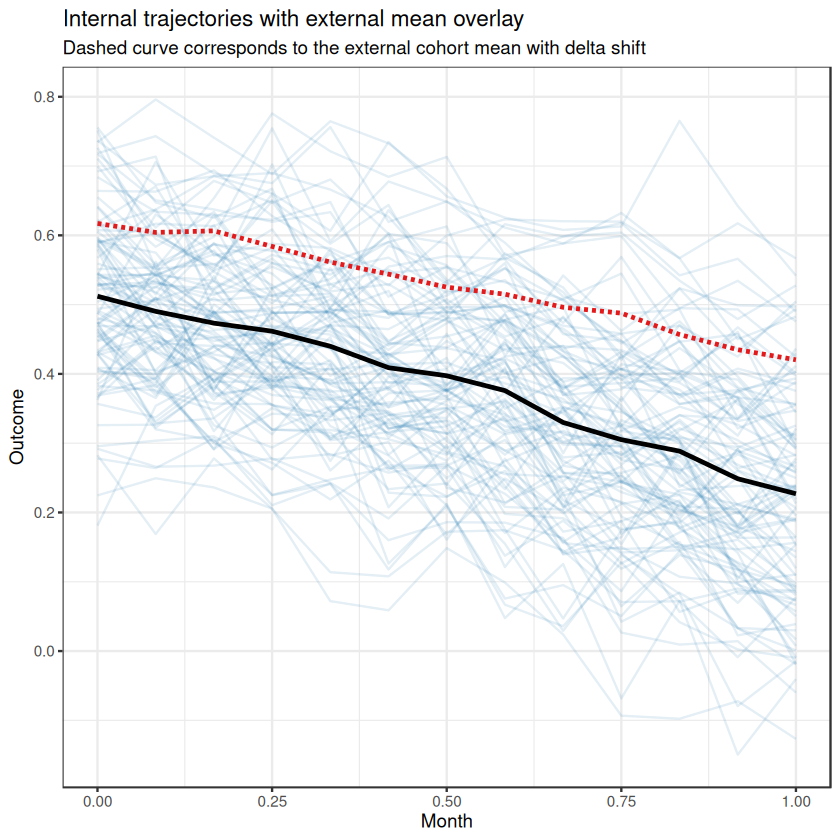

In [6]:
trajectory_internal <- purrr::map_dfr(seq_along(x), function(k) {
  tibble(
    patient = seq_len(design$J_internal),
    month = x[k],
    y = internal$y[, k]
  )
})

ggplot() +
  geom_line(data = trajectory_internal, aes(month, y, group = patient), alpha = 0.12, colour = "#1f78b4") +
  geom_line(data = visit_grid, aes(month, internal_mean), colour = "black", linewidth = 1) +
  geom_line(data = visit_grid, aes(month, external_mean), colour = "#e31a1c", linewidth = 1, linetype = "dashed") +
  labs(x = "Month", y = "Outcome",
       title = "Internal trajectories with external mean overlay",
       subtitle = "Dashed curve corresponds to the external cohort mean with delta shift") +
  theme_bw()


## Stan data lists

As in `linear_baad.R`, the Stan program expects both raw data and the Monte Carlo seeds (`xi`) used for the simulated-average likelihood.

In [7]:

stan_base <- list(
  fit_all = 0L,
  fit_local = 0L,
  J = design$J_internal,
  T = length(x),
  K = 2L,
  K_phi = 6L,
  y = internal$y,
  J_prime = design$J_external,
  T_prime = length(x),
  y_prime = external$y,
  x = x,
  x_prime = x,
  mu_phi_p = rep(0, 6),
  Sigma_phi_p = diag(rep(1, 6)),
  mu_delta_p = rep(0, 2),
  Sigma_delta_p = diag(rep(1, 2)),
  J_tilde = 500L,
  C = 4L,
  xi = array(rnorm(4L * 2L * (2L * 500L)), dim = c(4L, 2L, 2L * 500L))
)

local_data <- stan_base
local_data$fit_local <- 1L

list(
  y_dims = dim(stan_base$y),
  y_prime_dims = dim(stan_base$y_prime),
  J_tilde = stan_base$J_tilde,
  xi_dims = dim(stan_base$xi)
)


$y_dims
[1] 100  13

$y_prime_dims
[1] 100  13

$J_tilde
[1] 500

$xi_dims
[1]    4    2 1000

## Stan program

The chunk below copies `linear_mvn_approx.stan` into a post-specific directory so the notebook stays reproducible even if the upstream file changes.

In [10]:
stan_dir <- file.path("stan")
if (!dir.exists(stan_dir)) dir.create(stan_dir, recursive = TRUE)
stan_path <- file.path(stan_dir, "meta202_linear.stan")
file.copy(file.path("content", "baad-master", "linear_mvn_approx.stan"), stan_path, overwrite = TRUE)
stan_path


[1] FALSE

[1] "stan/meta202_linear.stan"

In [11]:
meta202_model <- rstan::stan_model(stan_path)
meta202_model


recompiling to avoid crashing R session



S4 class stanmodel 'anon_model' coded as follows:
functions {
  // numerically robust covariance estimate; ym is expected to be the
  // column wise mean
  matrix robust_cov(matrix y, row_vector ym) {
    matrix[cols(y),cols(y)] cov;
    //cov = yc' * yc /(rows(y) - 1);
    cov = crossprod(y - rep_matrix(ym, rows(y))) / (rows(y) - 1.0);
    return(0.5 * (cov + cov'));
  }
  real mvn_approx_lpdf(vector y_prime_bar, vector x_prime,
                       int J_prime,
                       vector delta,
                       vector mu_a, real beta,
                       vector sigma_a, real sigma_y,
                       matrix xi  // N(0,1) as K x J_tilde
                       ) {
    int J_tilde = cols(xi);
    int K       = rows(delta);
    int T_prime = rows(y_prime_bar);
    vector[T_prime] M_tilde;
    matrix[T_prime,T_prime] Sigma_tilde;
    vector[K] mu_a_tilde;
    matrix[K,J_tilde] a_tilde;
    matrix[T_prime,J_tilde] y_tilde;
    mu_a_tilde = mu_a + delta;
    a_tilde = re

## Local sampling

Set `run_sampling <- TRUE` after configuring Stan to fit the local-only case with `local_data`.


In [12]:

run_sampling <- TRUE

if (run_sampling) {
  sampling_args <- list(
    object = meta202_model,
    iter = 2000,
    warmup = 1000,
    chains = 4,
    refresh = 500,
    chain_id = 1L
  )
  local_fit <- do.call(rstan::sampling, c(list(data = local_data), sampling_args))
} else {
  message("Sampling skipped. Set `run_sampling <- TRUE` once rstan is configured for the local analysis.")
}


Running chain 1 with J_tilde_chain = 500...
Running chain 1 with J_tilde_chain = 500...

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Running chain 2 with J_tilde_chain = 1000...

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 1: 
Chain 1: Gradient evaluation took 0.000354 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.54 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Running chain 3 with J_tilde_chain = 500...
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 3).
Running chain Chain 42 : w
ithChain  2J: _Gradient evaluation took 0.000391 secondst
ildeChain _2c: h1000 transitions using 10 leapfrog steps per transition would take 3.91 seconds.a
inChain  2=:  Adjust your expectations accordingly!1
0Chain 020: .
.Chain .2
: 
Chain 2: Iteration:    1 / 2000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 4).
Chain 3: 
Chain 3: Gradient evaluation took 0.000486

In [13]:

if (exists("local_fit")) {
  parameters_of_interest <- true_values$parameter
  draws <- posterior::as_draws_df(local_fit, variables = parameters_of_interest)
  summaries <- posterior::summarise_draws(draws,
    mean = mean,
    sd = sd,
    q05 = ~posterior::quantile2(.x, 0.05),
    q95 = ~posterior::quantile2(.x, 0.95)
  ) %>%
    mutate(model = "local")
  summaries %>%
    dplyr::left_join(true_values, by = c("variable" = "parameter")) %>%
    dplyr::relocate(model)
} else {
  true_values
}


model,variable,mean,sd,q5,q95,value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
local,"eta_a[1,1]",1.5566243,0.2675902,1.127365735,2.00434701,NA
local,"eta_a[2,1]",-0.9199206,0.4235100,-1.633958233,-0.21893947,NA
local,"eta_a[1,2]",-0.3148728,0.2490019,-0.732032646,0.09330687,NA
local,"eta_a[2,2]",0.3283771,0.4231630,-0.362757881,1.03301411,NA
local,"eta_a[1,3]",0.1315018,0.2358636,-0.252614804,0.52287183,NA
local,"eta_a[2,3]",0.6747215,0.4114747,0.010500657,1.35786926,NA
local,"eta_a[1,4]",-0.6491033,0.2460041,-1.061958754,-0.25024073,NA
local,"eta_a[2,4]",-1.1009944,0.4231099,-1.814027468,-0.40431237,NA
local,"eta_a[1,5]",-0.1165137,0.2464251,-0.515975991,0.29188776,NA


## Bayesplot diagnostics

Use `bayesplot` to assess convergence and visualize posterior distributions. The plots below check trace plots, density overlays, and interval estimates.

### Trace plots

Check MCMC convergence by examining trace plots for the population-level parameters. Well-mixed chains should look like "hairy caterpillars" with no trends or systematic patterns.

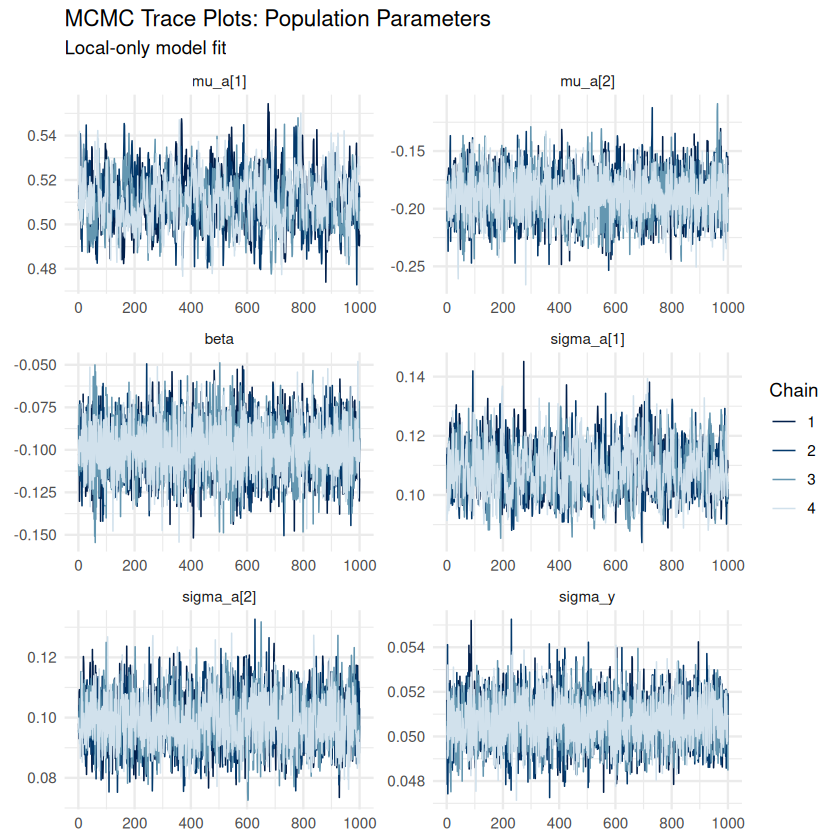

In [14]:
if (exists("local_fit")) {
  # Extract parameters of interest (excluding delta since local fit doesn't estimate it)
  local_params <- c("mu_a[1]", "mu_a[2]", "beta", "sigma_a[1]", "sigma_a[2]", "sigma_y")
  
  mcmc_trace(local_fit, pars = local_params, facet_args = list(ncol = 2)) +
    labs(title = "MCMC Trace Plots: Population Parameters",
         subtitle = "Local-only model fit") +
    theme_minimal()
}

### Posterior density plots

Visualize the posterior distributions overlaid across chains. Good mixing shows overlapping densities with no chain-specific modes.

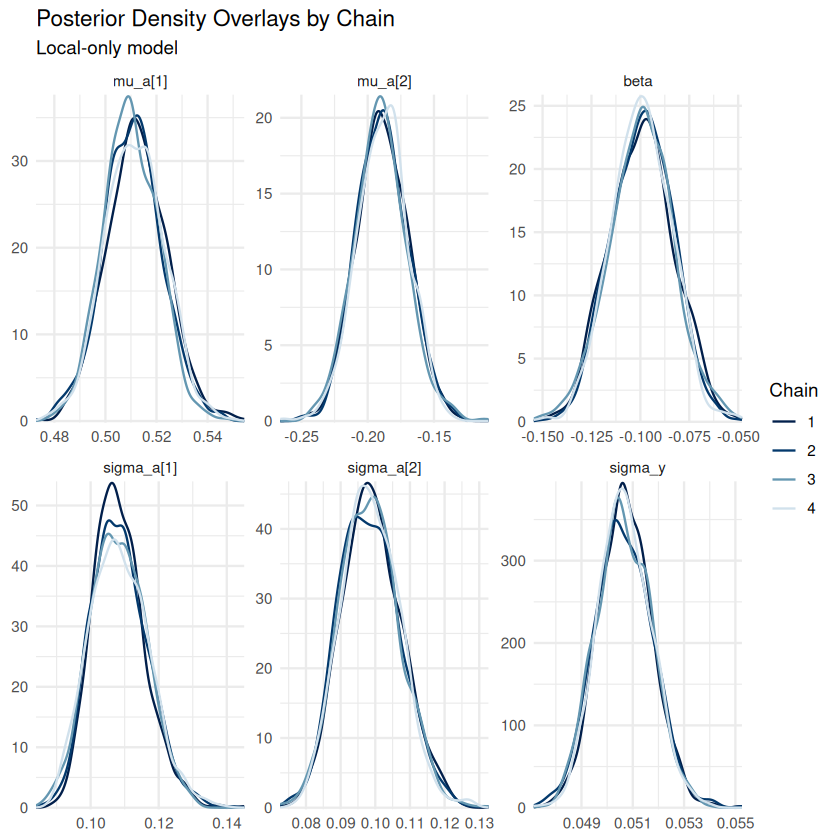

In [15]:
if (exists("local_fit")) {
  mcmc_dens_overlay(local_fit, pars = local_params) +
    labs(title = "Posterior Density Overlays by Chain",
         subtitle = "Local-only model") +
    theme_minimal()
}

### Posterior intervals with true values

Compare posterior credible intervals to the data-generating parameters. Vertical lines mark the true values used in the simulation.

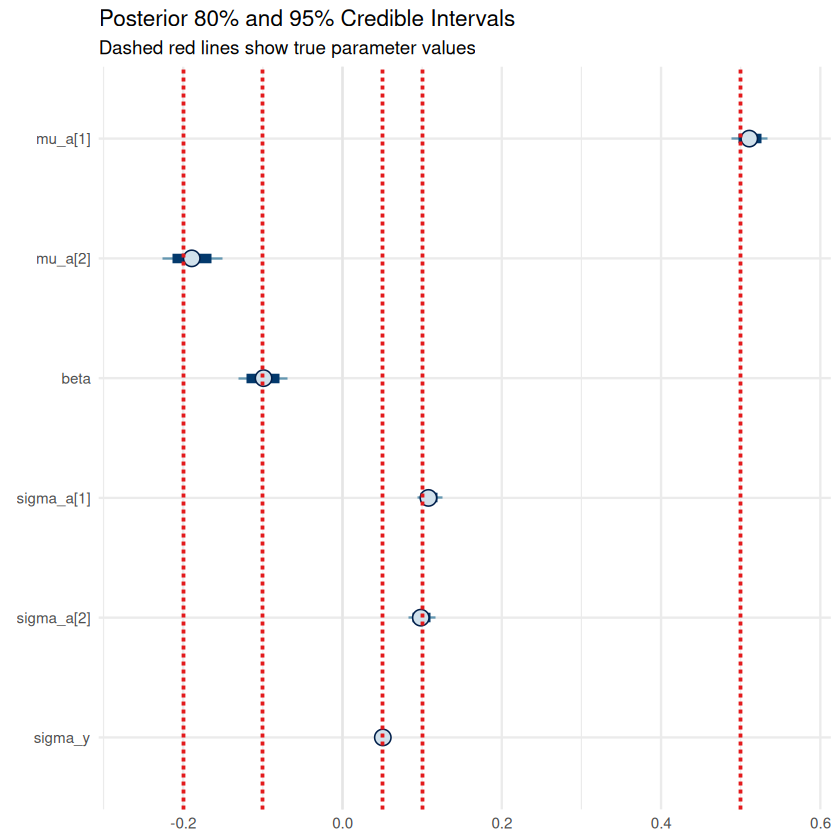

In [16]:
if (exists("local_fit")) {
  # Get true values for local parameters (exclude delta)
  true_local <- true_values %>% 
    filter(parameter %in% local_params)
  
  mcmc_intervals(local_fit, pars = local_params, 
                 prob = 0.8, prob_outer = 0.95) +
    geom_vline(data = true_local, 
               aes(xintercept = value), 
               color = "#e31a1c", linetype = "dashed", linewidth = 0.8) +
    labs(title = "Posterior 80% and 95% Credible Intervals",
         subtitle = "Dashed red lines show true parameter values") +
    theme_minimal()
}

### Pairs plot for correlation structure

Examine posterior correlations between parameters. The pairs plot reveals dependencies in the posterior geometry that HMC navigates.

Warning message:
“The following arguments were unrecognized and ignored: main”


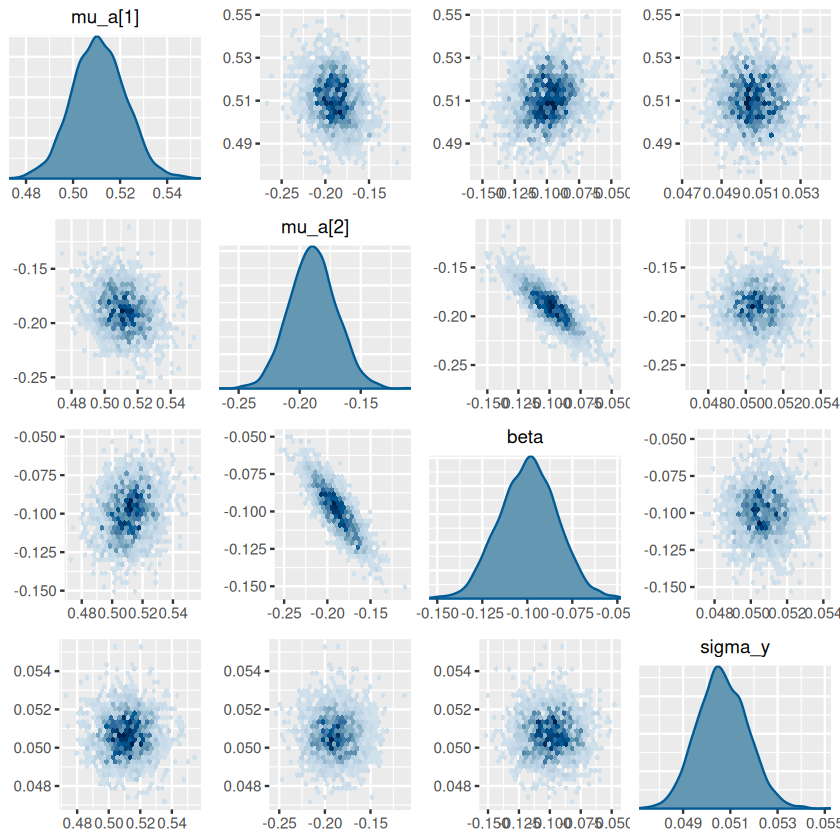

In [22]:
if (exists("local_fit")) {
  # mcmc_pairs returns a complex object that needs special handling
  posterior_array <- as.array(local_fit, pars = c("mu_a[1]", "mu_a[2]", "beta", "sigma_y"))
  
  mcmc_pairs(posterior_array,
             diag_fun = "dens",
             off_diag_fun = "hex",
             main = "Posterior Pairs Plot\nDiagonal: marginal densities, Off-diagonal: bivariate hexbin")
}

### Rank histogram (Rhat diagnostic)

The rank histogram shows how rank statistics are distributed across chains. Uniform bars indicate good mixing; systematic patterns suggest convergence issues.

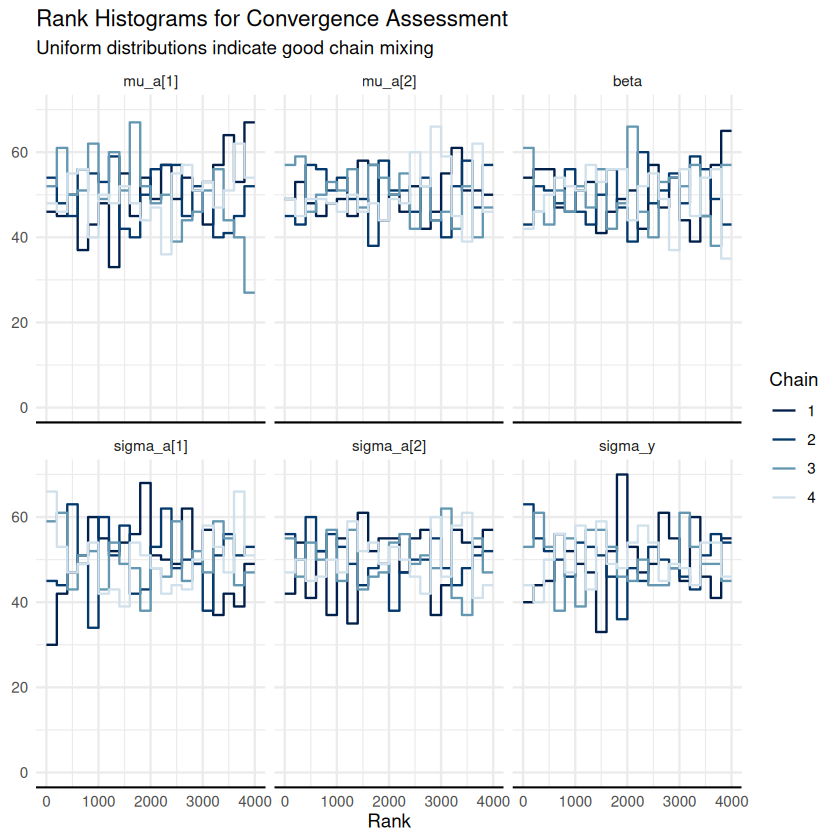

In [18]:
if (exists("local_fit")) {
  mcmc_rank_overlay(local_fit, pars = local_params) +
    labs(title = "Rank Histograms for Convergence Assessment",
         subtitle = "Uniform distributions indicate good chain mixing") +
    theme_minimal()
}

### Autocorrelation plots

Check for autocorrelation in the MCMC chains. Low autocorrelation indicates efficient sampling; high autocorrelation suggests the sampler is taking small, correlated steps.

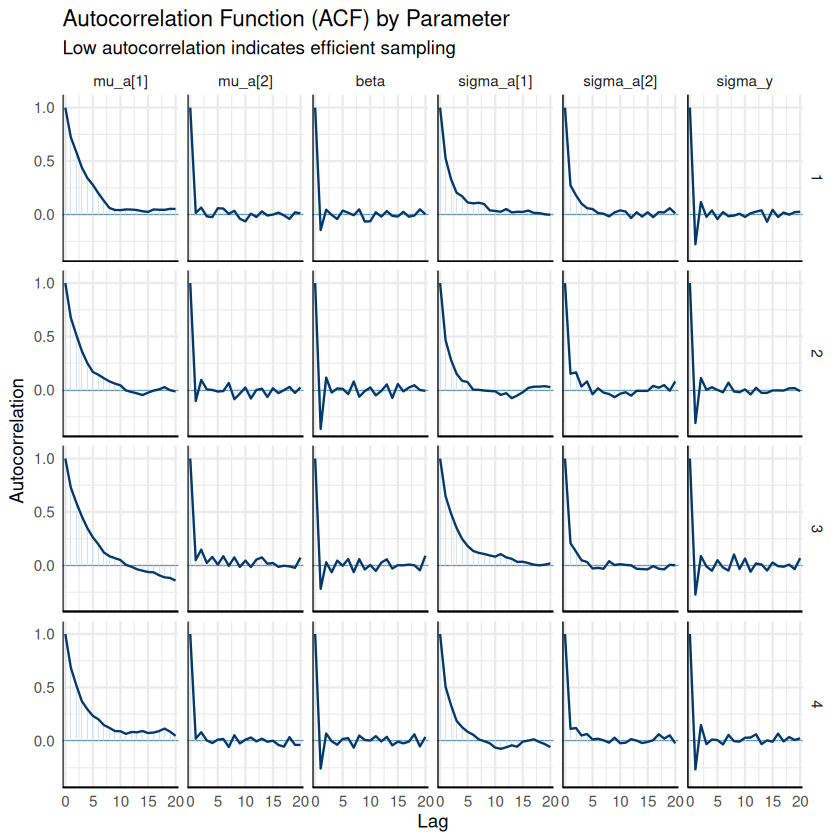

In [19]:
if (exists("local_fit")) {
  mcmc_acf(local_fit, pars = local_params, lags = 20) +
    labs(title = "Autocorrelation Function (ACF) by Parameter",
         subtitle = "Low autocorrelation indicates efficient sampling") +
    theme_minimal()
}